## Extract Data

In [ ]:
!unzip '/content/drive/MyDrive/training data/Training and Validation Data_2023_T1_COMP3010.zip' -d training

In [ ]:
!unzip '/content/drive/MyDrive/training data/Testing Data_Dubai_2023.zip' -d test

## Load Libraries

In [ ]:
## Python Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

## Neural Network
import torch as tr
import torchvision.datasets as datasets
from torchvision import models
import torchvision.transforms as trnsform
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from pylab import *

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Check Tourch Version

In [ ]:
print("Using torch", tr.__version__)

Using torch 1.13.1+cu116


## Checking Cuda Support (GPU)

In [ ]:
print(tr.cuda.device_count())
print(tr.cuda.get_device_name(0))

1
Tesla T4


#Assign cuda GPU located at location '0' to a variable


In [ ]:
cuda0 = tr.device('cuda:0')
cuda0

device(type='cuda', index=0)

## Seed Settings

In [ ]:
tr.cuda.manual_seed(1)
tr.backends.cudnn.deterministic = True
tr.backends.cudnn.benchmark = False

## Load Dataset

In [ ]:
# ToTenssor, Convert Image into Pixel of Range [0,255] and images are normalized.
transform = trnsform.Compose([trnsform.Resize(255),trnsform.CenterCrop(224),trnsform.ToTensor()])

traindata = datasets.ImageFolder(root='/content/training/Data/coral image classification/train',transform=transform)
# Val Data
valdata = datasets.ImageFolder(root='/content/training/Data/coral image classification/val',transform=transform)
## Test Data
testdata = datasets.ImageFolder(root='/content/test/Testing Data_2023/Testing Data_withLabels/CoralImageClassification',transform=transform)

## Train Data

* Train Data has 1117 Datapoints

In [ ]:
traindata

Dataset ImageFolder
    Number of datapoints: 1117
    Root location: /content/training/Data/coral image classification/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Val Data

* Val Data has 400 Datapoints

In [ ]:
valdata

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/training/Data/coral image classification/val
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Test Data

* Test Data has 400 Datapoints

In [ ]:
testdata

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/test/Testing Data_2023/Testing Data_withLabels/CoralImageClassification
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Classes of Dataset

In [ ]:
classes=traindata.classes
classes

['Coral Images', 'Non-Coral Images']

## Loading Data From Images into Varaibles

In [ ]:
X_trian = tr.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
X_test = tr.utils.data.DataLoader(testdata, batch_size=32, shuffle=True)
X_val = tr.utils.data.DataLoader(valdata, batch_size=32, shuffle=True)

## Printing Batch and Labels size

In [ ]:
batch, labels = next(iter(X_trian))

In [ ]:
print("Batch size", batch.size()[0])
print("Image size", batch.size()[2],"x",batch.size()[3])
print("Image Channel", batch.size()[1])
print("Label size,", labels.size())

Batch size 32
Image size 224 x 224
Image Channel 3
Label size, torch.Size([32])


## Ploting Images

In [ ]:
def functionlabel(label):
  if label == 1:
    return 'Coral Image'
  else:
    return 'Non-Coral Image'

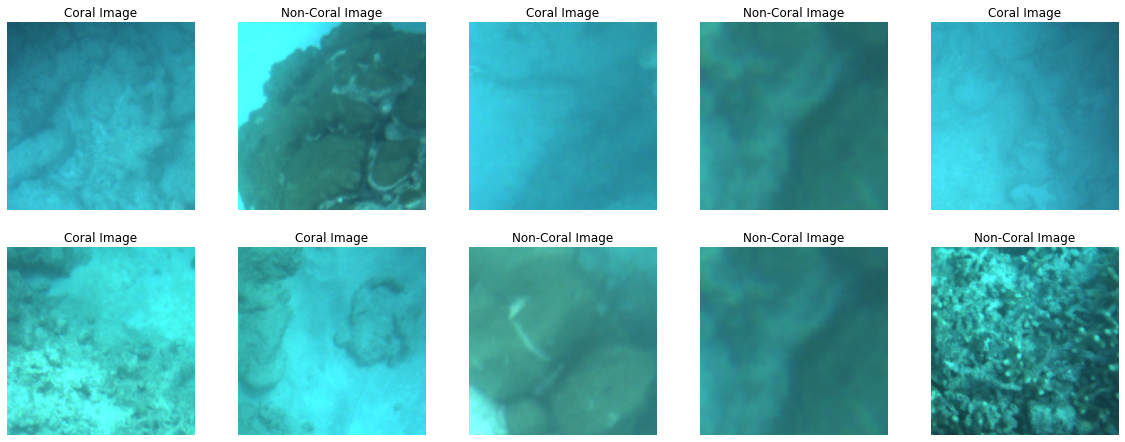

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(batch),10))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(batch[i].T)
    plt.title(functionlabel(labels[i]))
    plt.axis('off')     
plt.show()

## Labels

In [ ]:
y_train = np.array([y for x, y in iter(traindata)])
y_test = np.array([y for x, y in iter(testdata)])
y_val = np.array([y for x, y in iter(valdata)])

## Training Count

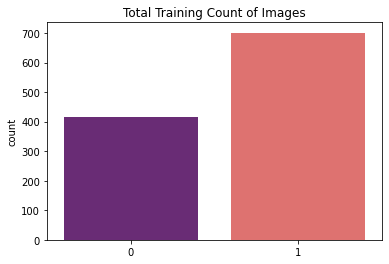

In [ ]:
f, ax = plt.subplots(figsize = (6,4))
plt.title('Total Training Count of Images')
sns.countplot(x = y_train, palette = 'magma')
plt.show()

## Test Count

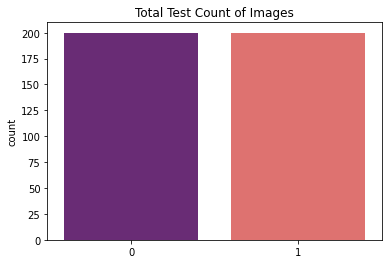

In [ ]:
f, ax = plt.subplots(figsize = (6,4))
plt.title('Total Test Count of Images')
sns.countplot(x = y_test, palette = 'magma')
plt.show()

## Creating ResNet50

In [ ]:
resnet = models.resnet50(pretrained=True).to(cuda0)

## Closing Final Layer

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

## Building Final Output Layer

In [ ]:
resnet.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.Dropout(0.2),
               nn.Linear(128, 64),
               nn.ReLU(inplace=True),
               nn.Linear(64, 2)).to(cuda0)

## Model Compiler

In [ ]:
number_epochs = 20
loss = nn.CrossEntropyLoss()
opti = optim.Adam(resnet.fc.parameters())
steprs = len(X_trian)

## Train Model

In [ ]:
loader =  {'training': X_trian,'val': X_val}
imagesize = {'training':len(X_trian.dataset),'val':len(X_val.dataset)}

In [ ]:
for epoch in range(20):
  print('Epoch {}/{}'.format(epoch+1, 20))
  print('-' * 10)
  
  for method in ['training', 'val']:
    if method == 'training':
      resnet.train()
    else:
      resnet.eval()

    current_loss = 0.0
    correct_accuracy = 0

    for inputs, labels in loader[method]:
      inputs = inputs.to(cuda0)
      labels = labels.to(cuda0)

      outputs = resnet(inputs)
      lossC = loss(outputs, labels)

      if method == 'training':
        opti.zero_grad()
        lossC.backward()
        opti.step()
        
      _, preds = tr.max(outputs, 1)
      current_loss += lossC.item() * inputs.size(0)
      correct_accuracy += tr.sum(preds == labels.data)

    loss_epoch = current_loss / imagesize[method]
    acc_epoch = correct_accuracy.double() / imagesize[method]    

    print('{} loss: {:.4f}, acc: {:.4f}'.format(method,loss_epoch,acc_epoch))   

Epoch 1/20
----------
training loss: 0.3231, acc: 0.8541
val loss: 0.1226, acc: 0.9450
Epoch 2/20
----------
training loss: 0.1011, acc: 0.9615
val loss: 0.0366, acc: 0.9900
Epoch 3/20
----------
training loss: 0.1475, acc: 0.9436
val loss: 0.0579, acc: 0.9825
Epoch 4/20
----------
training loss: 0.1089, acc: 0.9615
val loss: 0.0598, acc: 0.9825
Epoch 5/20
----------
training loss: 0.0916, acc: 0.9714
val loss: 0.0297, acc: 0.9900
Epoch 6/20
----------
training loss: 0.1102, acc: 0.9579
val loss: 0.0442, acc: 0.9900
Epoch 7/20
----------
training loss: 0.1512, acc: 0.9445
val loss: 0.1590, acc: 0.9350
Epoch 8/20
----------
training loss: 0.1634, acc: 0.9454
val loss: 0.0679, acc: 0.9800
Epoch 9/20
----------
training loss: 0.0952, acc: 0.9660
val loss: 0.0278, acc: 0.9900
Epoch 10/20
----------
training loss: 0.0635, acc: 0.9740
val loss: 0.0268, acc: 0.9900
Epoch 11/20
----------
training loss: 0.0909, acc: 0.9722
val loss: 0.0290, acc: 0.9900
Epoch 12/20
----------
training loss: 0.0

## Prediction on Test Data

In [ ]:
pred = []
actual_label = []
## Test Data evaluation
resnet.eval()
## Loop thorugh each test batch
for batch_id, (inputtest, targetlabel) in enumerate(X_test): 
  ## Using Cuda device
  inputtest, targetlabel = inputtest.cuda(), targetlabel.cuda()
  ## Predication
  ps = resnet(inputtest)
  prediction = tr.argmax(ps, 1)
  ## Model Appending
  pred.append(prediction.cpu().tolist())
  actual_label.append(targetlabel.cpu().tolist())

## Storing each batch list into single list

In [ ]:
## Prediction Labels
preds = []
for x in pred:
  for y in x:
    preds.append(y)

In [ ]:
# Target Labels
actual_labels = []
for x in actual_label:
  for y in x:
    actual_labels.append(y)

## Evaluation Metric for Test Data



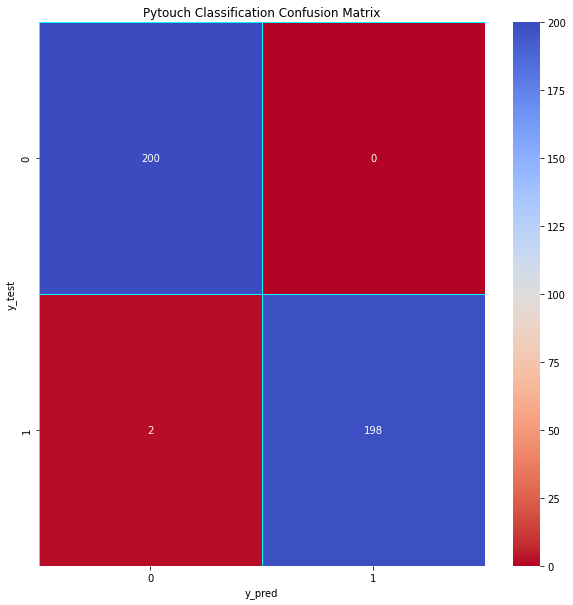

In [ ]:
# Creating the confusion matrix:
e_cm = confusion_matrix(actual_labels, preds)
# Visualization:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(e_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='coolwarm_r')
plt.title('ResNet Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
print(classification_report(actual_labels, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       1.00      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400

